# SWE pre-processing
This Notebook reads SWE station observations and precipitation station data (SCDNA, 1979-2018 Version 1.1; the complete data is available on Zenodo [here](https://zenodo.org/record/3953310#.YXnGQS1b1mA)) for a test river basin. It fills the gaps in the SWE station observations that are within the river basin, using quantile mapping with neighbouring SWE and precipitation station data.

Decisions:
- We only use SWE and precipitation station data within the test river basin, and do not apply any buffer around the basin. A distance-decay plot could be used to check the optimal buffer size.
- The water year definition is October 1st to September 30th of the next year. See user-specified variables below.
- The minimum correlation allowed to select an optimal donor station is set to 0.6 at the moment (no negative correlations selected). See user-specified variables below.
- The minimum number of overlapping observations required to calculate the correlation between two stations is set to 3 at the moment. See user-specified variables below.
- The minimum number of observations required to calculate a station's cdf is set to 10 at the moment. See user-specified variables below.
- We use a time window of +/- 7 days on either side of the infilling date for gap filling calculations. See user-specified variables below.
- The minimum number of observations required to calculate the KGE'' is set to 3 at the moment. See user-specified variables below.
- We perform a linear interpolation of the daily discharge data before calculating volumes, to fill in small data gap of maximum 15 days. See user-specified variables below.
- We evaluate the artificial gap filling quality based on the RMSE and the KGE'' decomposition.

The "Variables" section below is the only section a user will need to modify for testing different options for most of these decisions.

Notes:
- We do not look at data stationarity.

## Modules, settings & functions

In [64]:
# Import required modules
import datetime
from datetime import timedelta
import geopandas as gpd
import logging
%matplotlib notebook
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from pprint import pprint
from shapely.geometry import Point
import sys
import warnings
import xarray as xr

In [65]:
# Add scripts to the system path
sys.path.append('../scripts')

# Set up logging, configured for this workflow (see utilities.py)
from utilities import setup_logging, read_settings
setup_logging()

# Set up logging for this notebook
logger = logging.getLogger()

# Suppress misc. comments from being added to the log file
logging.getLogger('matplotlib.font_manager').disabled = True
logging.getLogger('matplotlib.pyplot').disabled = True

# Get the logger for fiona._env and suppress everything below CRITICAL level
fiona_env_logger = logging.getLogger('fiona._env')
fiona_env_logger.setLevel(logging.CRITICAL)

%load_ext autoreload
%autoreload 2

2024-10-24 15:22:00,282 - root - INFO - Logging setup complete. Log file: C:\Users\lauri\PycharmProjects\FROSTBYTE\logs\data_driven_forecasting_20241024_152200.log


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [66]:
# Save Notebook name to the log file
logger.debug(f'Notebook: 3_SWEPreprocessing')

In [67]:
# Read settings file
settings = read_settings('../settings/config_test_case.yaml', log_settings=True)
pprint(settings)

2024-10-24 15:22:02,712 - root - INFO - Settings logged from ../settings/config_test_case.yaml


{'SWE_obs_path': '../CH_data/CH_input_data/SWE_data.nc',
 'basins_dem_path': '../test_case_data/input_data/MERIT_Hydro_dem_',
 'basins_shp_path': '../CH_data/CH_input_data/nival_basins.shp',
 'domain': '2304',
 'output_data_path': '../CH_data/CH_output_data/',
 'plots_path': '../CH_data/CH_output_plots/',
 'precip_obs_path': '../CH_data/CH_input_data/P_data.nc',
 'streamflow_obs_path': '../CH_data/CH_input_data/Qobs_Camels.nc'}


In [68]:
# Import required functions
from functions import extract_stations_in_basin, stations_basin_map, data_availability_monthly_plots_1, data_availability_monthly_plots_2, qm_gap_filling, artificial_gap_filling, plots_artificial_gap_evaluation

## Variables

In [69]:
# Set user-specified variables
test_basin_id = settings['domain'] # Can override this with testbasin_id = <string of the testbasin id>, make sure that this id is in the input data files
flag_buffer_default, buffer_km_default = 0, 0 # buffer flag (0: no buffer around test basin, 1: buffer of value buffer_default around test basin) and buffer default value in km to be applied if flag = 1
month_start_water_year_default, day_start_water_year_default = 10, 1  # water year start
month_end_water_year_default, day_end_water_year_default = 9, 30  # water year end
min_obs_corr_default = 3 # the minimum number of overlapping observations required to calculate the correlation between 2 stations
min_obs_cdf_default = 10 # the minimum number of observations required to calculate a station's cdf
min_corr_default = 0.6 # the minimum correlation value required for donor stations to be selected
window_days_default = 7 # the number of days used on either side of the infilling date for gap filling calculations
min_obs_KGE_default = 3 # the minimum number of observations required to calculate the KGE''
max_gap_days_default = 15  # max. number of days for gaps allowed in the daily SWE data for the linear interpolation
iterations_default = 1 # the number of times we repeat the artificial gap filling (this should = 1 if artificial_gap_perc_default = 100, if artificial_gap_perc_default < 100, it can be set to > 1)
artificial_gap_perc_default = 100 # the percentage of observations to remove during the artificial gap filling for each station & month's first day

In [70]:
# Save the user-specified variables to the log file
logger.debug(f'test basin ID: {test_basin_id}')
logger.debug(f'buffer around basin for SWE and precip. stations selection (km): {buffer_km_default}')
logger.debug(f'water year start (month/day): {month_start_water_year_default}/{day_start_water_year_default}')
logger.debug(f'water year end (month/day): {month_end_water_year_default}/{day_end_water_year_default}')
logger.debug(f'min. number of obs. for correlation calculation: {min_obs_corr_default}')
logger.debug(f'min. number of obs. for building CDF: {min_obs_cdf_default}')
logger.debug(f'min. Pearson correlation for selection of donor stations: {min_corr_default}')
logger.debug(f'window length for infilling (days on either side of date): {window_days_default}')
logger.debug(f'min. number of obs. for KGE" calculation: {min_obs_KGE_default}')
logger.debug(f'linear interpolation maximum gap (days): {max_gap_days_default}')
logger.debug(f'percentage of observations to remove for artificial gap filling: {artificial_gap_perc_default}')

## Read data

In [71]:
# Read SWE station observations NetCDF
SWE_stations_ds = xr.open_dataset(settings['SWE_obs_path'])
SWE_stations_ds = SWE_stations_ds.assign_coords({'lon':SWE_stations_ds.lon, 'lat':SWE_stations_ds.lat, 'station_id':SWE_stations_ds.station_id}).swe
#SWE_stations_ds = SWE_stations_ds.assign_coords({'lon':SWE_stations_ds.lon, 'lat':SWE_stations_ds.lat, 'station_name':SWE_stations_ds.station_name}).snw
SWE_stations_ds = SWE_stations_ds.to_dataset()

display(SWE_stations_ds)

<xarray.Dataset>
Dimensions:     (station_id: 99280, time: 8704)
Coordinates:
  * time        (time) datetime64[ns] 1998-09-01 1998-09-02 ... 2022-06-30
    lat         (station_id) float64 5.3e+04 5.3e+04 ... 3.24e+05 3.24e+05
    lon         (station_id) float64 4.74e+05 4.75e+05 ... 8.37e+05 8.38e+05
    Station_ID  (station_id) object '474000.0_53000.0' ... '838000.0_324000.0'
  * station_id  (station_id) int64 0 1 2 3 4 5 ... 99275 99276 99277 99278 99279
Data variables:
    swe         (time, station_id) float64 ...

In [72]:
SWE_stations_ds = SWE_stations_ds.rename({"Station_ID": "station_name"})
print(SWE_stations_ds)

<xarray.Dataset>
Dimensions:       (station_id: 99280, time: 8704)
Coordinates:
  * time          (time) datetime64[ns] 1998-09-01 1998-09-02 ... 2022-06-30
    lat           (station_id) float64 5.3e+04 5.3e+04 ... 3.24e+05 3.24e+05
    lon           (station_id) float64 4.74e+05 4.75e+05 ... 8.37e+05 8.38e+05
    station_name  (station_id) object '474000.0_53000.0' ... '838000.0_324000.0'
  * station_id    (station_id) int64 0 1 2 3 4 ... 99275 99276 99277 99278 99279
Data variables:
    swe           (time, station_id) float64 ...


In [73]:
#Anpassung 10.10.24 SWE_Camels_testbasin_id speichern --> PCA funktioniert nicht mit nur einer Datenreihe
# --> entkomentieren zur visualisierung das es mit camels nicht funktioniert --> gleichzeitig müsste im 4_ die zelle mit diesem datum entkomentiert werden
#SWE_testbasin_ds = SWE_stations_ds.where(SWE_stations_ds.station_id==test_basin_id, drop=True)
#SWE_testbasin_ds = SWE_testbasin_ds.set_index({"station_id":"station_id"})
#output_filename = f"SWE_Camels_{test_basin_id}.nc"
#SWE_testbasin_ds.to_netcdf(f"{settings['output_data_path']}{output_filename}")

In [74]:
# Convert SWE stations DataArray to GeoDataFrame for further analysis
"""
data = {'station_id': SWE_stations_ds.station_id.data, 
        'lon': SWE_stations_ds.lon.data, 
        'lat': SWE_stations_ds.lat.data} 
df = pd.DataFrame(data)
geometry = [Point(xy) for xy in zip(df['lon'], df['lat'])]
crs = "EPSG:4326"
SWE_stations_gdf = gpd.GeoDataFrame(df, crs=crs, geometry=geometry)

display(SWE_stations_gdf)
"""

print(SWE_stations_ds.station_id.data.shape)
print(SWE_stations_ds.lon.data.shape)
print(SWE_stations_ds.lat.data.shape)
data = {'station_id': SWE_stations_ds.station_id.data, 
        'lon': SWE_stations_ds.lon.data, 
        'lat': SWE_stations_ds.lat.data} 
df = pd.DataFrame(data)
geometry = [Point(xy) for xy in zip(df['lon'], df['lat'])]
crs = "EPSG:21781"
SWE_stations_gdf = gpd.GeoDataFrame(df, crs=crs, geometry=geometry)

#SWE_stations_gdf_lv95 = SWE_stations_gdf.to_crs("EPSG:2056")

display(SWE_stations_gdf)



(99280,)
(99280,)
(99280,)


,station_id,lon,lat,geometry
0,0,474000.0,53000.0,POINT (474000.000 53000.000)
1,1,475000.0,53000.0,POINT (475000.000 53000.000)
2,2,476000.0,53000.0,POINT (476000.000 53000.000)
3,3,477000.0,53000.0,POINT (477000.000 53000.000)
4,4,478000.0,53000.0,POINT (478000.000 53000.000)
...,...,...,...,...
99275,99275,834000.0,324000.0,POINT (834000.000 324000.000)
99276,99276,835000.0,324000.0,POINT (835000.000 324000.000)
99277,99277,836000.0,324000.0,POINT (836000.000 324000.000)
99278,99278,837000.0,324000.0,POINT (837000.000 324000.000)


In [75]:
#LNU koordinaten in LV95 umwandeln
# Überprüfen der Dimensionen der Datenarrays
print(SWE_stations_ds.station_id.data.shape)
print(SWE_stations_ds.lon.data.shape)
print(SWE_stations_ds.lat.data.shape)

# Erstellen des DataFrames
data = {
    'station_id': SWE_stations_ds.station_id.data,
    'lon': SWE_stations_ds.lon.data,
    'lat': SWE_stations_ds.lat.data
}
df = pd.DataFrame(data)

# Erstellen der Geometrien
geometry = [Point(xy) for xy in zip(df['lon'], df['lat'])]

# Definieren des ursprünglichen Koordinatensystems (EPSG:21781)
crs = "EPSG:21781"
SWE_stations_gdf = gpd.GeoDataFrame(df, crs=crs, geometry=geometry)

# Anzeigen des ursprünglichen GeoDataFrame
print("Vor der Umwandlung (EPSG:21781):")
display(SWE_stations_gdf)

# Umwandeln in das neue Koordinatensystem (EPSG:2056)
SWE_stations_gdf_lv95 = SWE_stations_gdf.to_crs("EPSG:2056")

# Anzeigen des umgewandelten GeoDataFrame
print("Nach der Umwandlung (EPSG:2056):")
display(SWE_stations_gdf_lv95)

# Überprüfung der Koordinaten nach Umwandlung
print("Umgewandelte Koordinaten (EPSG:2056):")
print(SWE_stations_gdf_lv95[['geometry']])
SWE_stations_gdf = SWE_stations_gdf_lv95

(99280,)
(99280,)
(99280,)
Vor der Umwandlung (EPSG:21781):


,station_id,lon,lat,geometry
0,0,474000.0,53000.0,POINT (474000.000 53000.000)
1,1,475000.0,53000.0,POINT (475000.000 53000.000)
2,2,476000.0,53000.0,POINT (476000.000 53000.000)
3,3,477000.0,53000.0,POINT (477000.000 53000.000)
4,4,478000.0,53000.0,POINT (478000.000 53000.000)
...,...,...,...,...
99275,99275,834000.0,324000.0,POINT (834000.000 324000.000)
99276,99276,835000.0,324000.0,POINT (835000.000 324000.000)
99277,99277,836000.0,324000.0,POINT (836000.000 324000.000)
99278,99278,837000.0,324000.0,POINT (837000.000 324000.000)


Nach der Umwandlung (EPSG:2056):


,station_id,lon,lat,geometry
0,0,474000.0,53000.0,POINT (2474000.000 1053000.000)
1,1,475000.0,53000.0,POINT (2475000.000 1053000.000)
2,2,476000.0,53000.0,POINT (2476000.000 1053000.000)
3,3,477000.0,53000.0,POINT (2477000.000 1053000.000)
4,4,478000.0,53000.0,POINT (2478000.000 1053000.000)
...,...,...,...,...
99275,99275,834000.0,324000.0,POINT (2834000.000 1324000.000)
99276,99276,835000.0,324000.0,POINT (2835000.000 1324000.000)
99277,99277,836000.0,324000.0,POINT (2836000.000 1324000.000)
99278,99278,837000.0,324000.0,POINT (2837000.000 1324000.000)


Umgewandelte Koordinaten (EPSG:2056):
                              geometry
0      POINT (2474000.000 1053000.000)
1      POINT (2475000.000 1053000.000)
2      POINT (2476000.000 1053000.000)
3      POINT (2477000.000 1053000.000)
4      POINT (2478000.000 1053000.000)
...                                ...
99275  POINT (2834000.000 1324000.000)
99276  POINT (2835000.000 1324000.000)
99277  POINT (2836000.000 1324000.000)
99278  POINT (2837000.000 1324000.000)
99279  POINT (2838000.000 1324000.000)

[99280 rows x 1 columns]


In [76]:
# Plot SWE stations available

# Laden der Weltkarte
world_gdf = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Filter für Europa anwenden
EU_albers_gdf = world_gdf[world_gdf['continent'] == 'Europe']

# Umwandeln ins LV95-Koordinatensystem (EPSG:2056)
EU_LV95_gdf = EU_albers_gdf.to_crs(epsg=2056)

# Plot der Europa-Karte im Schweizer Koordinatensystem LV95
ax = EU_LV95_gdf.plot(linewidth=1, edgecolor='grey', color='white')

# Annahme: SWE_stations_gdf ist bereits geladen
# Umprojektion der SWE-Stationen in das LV95-Koordinatensystem
SWE_stations_LV95_gdf = SWE_stations_gdf.copy().to_crs(epsg=2056)

# Plot der SWE-Stationen auf der Europa-Karte
SWE_stations_LV95_gdf.plot(ax=ax, color='b', alpha=.5, markersize=5)

# Kartengrenzen setzen, basierend auf den minimalen und maximalen Koordinaten in Europa
minx, miny, maxx, maxy = np.nanmin(EU_LV95_gdf.geometry.bounds.minx), np.nanmin(EU_LV95_gdf.geometry.bounds.miny), np.nanmax(EU_LV95_gdf.geometry.bounds.maxx), np.nanmax(EU_LV95_gdf.geometry.bounds.maxy)
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

# Plot-Details anpassen
ax.margins(0)
ax.tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)
ax.set_facecolor('azure')
plt.title('SWE stations available in Europe (LV95)')
plt.text(.01, .01, 'Total stations=' + str(len(SWE_stations_LV95_gdf.index)), ha='left', va='bottom', transform=ax.transAxes)
plt.tight_layout()

plt.show()



"""
world_gdf = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
NA_albers_gdf = world_gdf[world_gdf['continent']=='North America'].to_crs("ESRI:102008")
ax = NA_albers_gdf.plot(linewidth=1, edgecolor='grey', color='white')
SWE_stations_albers_gdf = SWE_stations_gdf.copy().to_crs("ESRI:102008")
SWE_stations_albers_gdf.plot(ax=ax, color='b', alpha=.5, markersize=5)             
minx, miny, maxx, maxy = np.nanmin(NA_albers_gdf.geometry.bounds.minx),np.nanmin(NA_albers_gdf.geometry.bounds.miny),np.nanmax(NA_albers_gdf.geometry.bounds.maxx),np.nanmax(NA_albers_gdf.geometry.bounds.maxy)
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)
ax.margins(0)
ax.tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)
ax.set_facecolor('azure')
plt.title('SWE stations available')
plt.text(.01, .01,'Total stations='+str(len(SWE_stations_albers_gdf.index)), ha='left', va='bottom', transform=ax.transAxes)
plt.tight_layout();
"""

<IPython.core.display.Javascript object>

'\nworld_gdf = gpd.read_file(gpd.datasets.get_path(\'naturalearth_lowres\'))\nNA_albers_gdf = world_gdf[world_gdf[\'continent\']==\'North America\'].to_crs("ESRI:102008")\nax = NA_albers_gdf.plot(linewidth=1, edgecolor=\'grey\', color=\'white\')\nSWE_stations_albers_gdf = SWE_stations_gdf.copy().to_crs("ESRI:102008")\nSWE_stations_albers_gdf.plot(ax=ax, color=\'b\', alpha=.5, markersize=5)             \nminx, miny, maxx, maxy = np.nanmin(NA_albers_gdf.geometry.bounds.minx),np.nanmin(NA_albers_gdf.geometry.bounds.miny),np.nanmax(NA_albers_gdf.geometry.bounds.maxx),np.nanmax(NA_albers_gdf.geometry.bounds.maxy)\nax.set_xlim(minx, maxx)\nax.set_ylim(miny, maxy)\nax.margins(0)\nax.tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)\nax.set_facecolor(\'azure\')\nplt.title(\'SWE stations available\')\nplt.text(.01, .01,\'Total stations=\'+str(len(SWE_stations_albers_gdf.index)), ha=\'left\', va=\'bottom\', transform=ax.transAxes)\nplt.tight_layout();\n'

You can zoom into the map with the rectangle icon ("zoom to rectangle") showing below the figure. Here, you see that the sample data contains SWE station observations for an area around two river basins, one in the USA and one in Canada, for which we also have all the data needed to run this workflow (e.g., discharge observations).

In [77]:
# Read meteorological station observations NetCDF
met_stations_ds = xr.open_dataset(settings['precip_obs_path'])

display(met_stations_ds)
print(met_stations_ds.LLE)

<xarray.Dataset>
Dimensions:        (lle: 3, nday: 10227, station: 404)
Coordinates:
  * station        (station) int64 54 338 630 405 409 73 ... 578 593 607 609 818
  * nday           (nday) datetime64[ns] 1996-10-02 1996-10-03 ... 2024-10-01
  * lle            (lle) object 'lon' 'lat' 'elev'
Data variables:
    LLE            (station, lle) int64 ...
    precipitation  (nday, station) float64 ...

<xarray.DataArray 'LLE' (station: 404, lle: 3)>
array([[2708189, 1173789,       0],
       [2734016, 1165552,       0],
       [2735685, 1181966,       0],
       ...,
       [2810560, 1170640,       0],
       [2802720, 1175230,       0],
       [2831170, 1169340,       0]], dtype=int64)
Coordinates:
  * station  (station) int64 54 338 630 405 409 73 ... 574 578 593 607 609 818
  * lle      (lle) object 'lon' 'lat' 'elev'


In [78]:
# LNU --> nstn hinzufügen
#Erstelle eine neue durchnummerierte Variable für 'nstn'
nstn_values = np.arange(met_stations_ds.dims['station'])  # Erzeugt eine Liste [0, 1, 2, ..., N-1], wobei N die Anzahl der Stationen ist

# Füge diese Variable als 'nstn' hinzu
met_stations_ds['nstn'] = xr.DataArray(nstn_values, dims=['station'])

display(met_stations_ds)

<xarray.Dataset>
Dimensions:        (lle: 3, nday: 10227, station: 404)
Coordinates:
  * station        (station) int64 54 338 630 405 409 73 ... 578 593 607 609 818
  * nday           (nday) datetime64[ns] 1996-10-02 1996-10-03 ... 2024-10-01
  * lle            (lle) object 'lon' 'lat' 'elev'
Data variables:
    LLE            (station, lle) int64 2708189 1173789 0 ... 2831170 1169340 0
    precipitation  (nday, station) float64 ...
    nstn           (station) int32 0 1 2 3 4 5 6 ... 397 398 399 400 401 402 403

In [79]:
# LNU ich versuche "Convert meteorological stations DataSet to GeoDataFrame for further analysis"
lon = met_stations_ds.LLE[:, 0].values  # Extract longitude
lat = met_stations_ds.LLE[:, 1].values  # Extract latitude
elev = met_stations_ds.LLE[:, 2].values  # Extract elevation
station = met_stations_ds.station[:].values

# Step 2: Create a DataFrame
data = {
    'lon': lon, 
    'lat': lat,
    'elev': elev,
    'station': station
}
df = pd.DataFrame(data)

# Step 3: Create geometry for GeoDataFrame
geometry = [Point(xy) for xy in zip(df['lon'], df['lat'])]

# Step 4: Create the GeoDataFrame (ensure correct CRS)
# If your coordinates are in EPSG:21781, set crs accordingly
met_stations_gdf = gpd.GeoDataFrame(df, crs="EPSG:2056", geometry=geometry)

# Display the GeoDataFrame
print(met_stations_gdf)

         lon      lat  elev  station                         geometry
0    2708189  1173789     0       54  POINT (2708189.000 1173789.000)
1    2734016  1165552     0      338  POINT (2734016.000 1165552.000)
2    2735685  1181966     0      630  POINT (2735685.000 1181966.000)
3    2752687  1164036     0      405  POINT (2752687.000 1164036.000)
4    2771282  1148120     0      409  POINT (2771282.000 1148120.000)
..       ...      ...   ...      ...                              ...
399  2808650  1123700     0      578  POINT (2808650.000 1123700.000)
400  2788700  1151730     0      593  POINT (2788700.000 1151730.000)
401  2810560  1170640     0      607  POINT (2810560.000 1170640.000)
402  2802720  1175230     0      609  POINT (2802720.000 1175230.000)
403  2831170  1169340     0      818  POINT (2831170.000 1169340.000)

[404 rows x 5 columns]


In [80]:
# Convert meteorological stations DataSet to GeoDataFrame for further analysis
"""
data = {'lon': met_stations_ds.LLE.data[1], 
        'lat': met_stations_ds.LLE.data[0],
        'elev': met_stations_ds.LLE.data[2]} 
df = pd.DataFrame(data)
geometry = [Point(xy) for xy in zip(df['lon'], df['lat'])]
met_stations_gdf = gpd.GeoDataFrame(df, crs="EPSG:4326", geometry=geometry)#EPSG:21781

display(met_stations_gdf)
"""



'\ndata = {\'lon\': met_stations_ds.LLE.data[1], \n        \'lat\': met_stations_ds.LLE.data[0],\n        \'elev\': met_stations_ds.LLE.data[2]} \ndf = pd.DataFrame(data)\ngeometry = [Point(xy) for xy in zip(df[\'lon\'], df[\'lat\'])]\nmet_stations_gdf = gpd.GeoDataFrame(df, crs="EPSG:4326", geometry=geometry)#EPSG:21781\n\ndisplay(met_stations_gdf)\n'

In [81]:
# Plot meteorological stations available
"""
NA_gdf = world_gdf[world_gdf['continent']=='North America']
ax = NA_gdf.plot(linewidth=1, edgecolor='grey', color='white')
plt.scatter(met_stations_gdf.lon, met_stations_gdf.lat, color='b', alpha=.5, s=5)
minx, miny, maxx, maxy = np.nanmin(NA_gdf.geometry.bounds.minx),np.nanmin(NA_gdf.geometry.bounds.miny),np.nanmax(NA_gdf.geometry.bounds.maxx),np.nanmax(NA_gdf.geometry.bounds.maxy)
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)
ax.margins(0)
ax.tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)
ax.set_facecolor('azure')
plt.title('Meteorological stations available')
plt.text(.01, .01,'Total stations='+str(len(met_stations_gdf.index)), ha='left', va='bottom', transform=ax.transAxes)
plt.tight_layout();
"""

# Lade die Weltkarte
world_gdf = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Transformiere die Weltkarte in das LV95-Koordinatensystem (EPSG:21781)
# Bei einer Weltkarte kann es sinnvoller sein, nur die Schweiz oder Europa zu betrachten.
# Du kannst auch nur die Länder der EU oder angrenzende Länder wählen.
swiss_gdf = world_gdf[world_gdf['name'] == 'Switzerland'].to_crs(epsg=2056)

# Erstelle eine größere Europakarte, die in LV95 transformiert ist, wenn gewünscht
# Hier werden die Umrisse der Länder verwendet, um die relevante Region anzuzeigen
europe_gdf = world_gdf[world_gdf['continent'] == 'Europe'].to_crs(epsg=2056)

# Erstelle einen Plot
fig, ax = plt.subplots(figsize=(10, 10))

# Plot der Europäischen Karte im LV95-Koordinatensystem
europe_gdf.plot(ax=ax, linewidth=0.5, edgecolor='grey', color='lightgrey')

# Überlagere die meteorologischen Stationsdaten
plt.scatter(met_stations_gdf.geometry.x, met_stations_gdf.geometry.y, color='b', alpha=0.5, s=5)

# Setze die Grenzen der Achsen
minx, miny, maxx, maxy = europe_gdf.total_bounds
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

# Weitere Einstellungen für die Darstellung
ax.margins(0)
ax.tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)
ax.set_facecolor('azure')

# Titel und Text auf der Karte
plt.title('Meteorological Stations in Switzerland (LV95 Coordinate System)')
plt.text(0.01, 0.01, f'Total stations={len(met_stations_gdf.index)}', ha='left', va='bottom', transform=ax.transAxes)

plt.tight_layout()
plt.show()



<IPython.core.display.Javascript object>

Same comments as for the SWE map above. Note that not all meteorological stations contained in this dataset have precipitation data. Some only have temperature for example. We will sort out the stations with precipitation later in this workflow.

## Extract SWE and precipitation stations in the basin

In [82]:
# Read test basin's shapefile
basins_gdf = gpd.read_file(settings['basins_shp_path'])
shp_testbasin_gdf = basins_gdf.loc[basins_gdf.Station_ID == test_basin_id]
#basins_gdf['gauge_id'] = basins_gdf['gauge_id'].astype(str)
#shp_testbasin_gdf = basins_gdf.loc[basins_gdf.gauge_id == test_basin_id]

print("basins_gdf:")
print(basins_gdf.dtypes)  # Zeigt die Datentypen des basins_gdf
print("Datentyp test_basin_id:")
print(type(test_basin_id))  # Zeigt den Datentyp von test_basin_id

display(shp_testbasin_gdf)

basins_gdf:
gauge_id       float64
ID6             object
gauge_name      object
water_body      object
type            object
country         object
Shape_Leng     float64
Shape_Area     float64
ORIG_FID         int64
Station_ID      object
Station_Na      object
geometry      geometry
dtype: object
Datentyp test_basin_id:
<class 'str'>


,gauge_id,ID6,gauge_name,water_body,type,country,Shape_Leng,Shape_Area,ORIG_FID,Station_ID,Station_Na,geometry
32,2304.0,OdFZer,Zernez-Punt_la_Drossa,Ova_dal_Fuorn,stream,CH,38499.410488,5.525328e+07,127,2304,Zernez-Pun,"POLYGON Z ((2811745.906 1175340.125 0.000, 281..."


In [83]:
# Plot a map of the test basin and of the SWE and meteorological stations available
print("CRS von shp_testbasin_gdf:", shp_testbasin_gdf.crs)
print("CRS von SWE_stations_gdf:", SWE_stations_gdf.crs)
print("CRS von met_stations_gdf:", met_stations_gdf.crs)
fig = stations_basin_map(shp_testbasin_gdf, test_basin_id, SWE_stations_gdf, met_stations_gdf, flag=flag_buffer_default, buffer_km=buffer_km_default)

CRS von shp_testbasin_gdf: epsg:2056
CRS von SWE_stations_gdf: EPSG:2056
CRS von met_stations_gdf: EPSG:2056


<IPython.core.display.Javascript object>

We will now extract the SWE and meteorological stations that fall within the basin only.

In [84]:
# Extract SWE stations within test basin (+ optional buffer) and save info to DataFrame
SWE_stations_in_basin = extract_stations_in_basin(SWE_stations_gdf, shp_testbasin_gdf, test_basin_id, buffer_km=buffer_km_default)[0]

display(SWE_stations_in_basin)

print('There are',str(len(SWE_stations_in_basin.index)),'SWE stations within the test basin.')

,station_id,lon,lat,geometry,basin
41952,41952,816000.0,167000.0,POINT (2816000.000 1167000.000),2304
41953,41953,817000.0,167000.0,POINT (2817000.000 1167000.000),2304
41954,41954,818000.0,167000.0,POINT (2818000.000 1167000.000),2304
42317,42317,816000.0,168000.0,POINT (2816000.000 1168000.000),2304
42318,42318,817000.0,168000.0,POINT (2817000.000 1168000.000),2304
42319,42319,818000.0,168000.0,POINT (2818000.000 1168000.000),2304
42681,42681,815000.0,169000.0,POINT (2815000.000 1169000.000),2304
42682,42682,816000.0,169000.0,POINT (2816000.000 1169000.000),2304
42683,42683,817000.0,169000.0,POINT (2817000.000 1169000.000),2304
42684,42684,818000.0,169000.0,POINT (2818000.000 1169000.000),2304


There are 56 SWE stations within the test basin.


In [85]:
# Extract meteorological stations within test basin (+ optional buffer) and save info to DataFrame
met_stations_in_basin = extract_stations_in_basin(met_stations_gdf, shp_testbasin_gdf, test_basin_id, buffer_km=buffer_km_default)[0]

display(met_stations_in_basin)

print('There are',str(len(met_stations_in_basin.index)),'meteorological stations within the test basin.')

,lon,lat,elev,station,geometry,basin
117,2816494,1170225,0,606,POINT (2816494.000 1170225.000),2304


There are 1 meteorological stations within the test basin.


In [86]:
# Plot map of test basin (+ optional buffer) and the extracted stations
fig = stations_basin_map(shp_testbasin_gdf, test_basin_id, SWE_stations_in_basin, met_stations_in_basin, flag=flag_buffer_default, buffer_km=buffer_km_default)

<IPython.core.display.Javascript object>

We will now extract the SWE station observations in the test basin and make a few plots.

In [87]:
# Sub-select SWE station observations in test basin and convert to Pandas DataFrame
SWE_testbasin_ds = SWE_stations_ds.sel(station_id = SWE_stations_in_basin["station_id"].values)

# Convert test basin SWE data DataSet to Pandas DataFrame for further analysis
SWE_testbasin_df = SWE_testbasin_ds.to_dataframe().drop(columns=['lon','lat','station_name']).unstack()['swe'].T
#SWE_testbasin_df = SWE_testbasin_ds.to_dataframe().drop(columns=['lon','lat','station_name']).unstack()['snw'].T
SWE_testbasin_df['date'] = SWE_testbasin_df.index.normalize()
SWE_testbasin_df = SWE_testbasin_df.set_index('date')

display(SWE_testbasin_df)

station_id,41952,41953,41954,42317,42318,42319,42681,42682,42683,42684,...,44503,44504,44505,44506,44507,44508,44509,44867,44868,44869
date,,,,,,,,,,,,,,,,,,,,,
1998-09-01,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.000,...,0.0,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.000,0.000
1998-09-02,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.000,...,0.0,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.000,0.000
1998-09-03,0.010,0.003,0.098,0.010,0.001,0.002,0.0,0.011,0.010,0.006,...,0.0,0.163,0.002,0.0,0.164,0.032,0.390,0.023,0.031,0.279
1998-09-04,0.007,0.002,0.032,0.006,0.000,0.001,0.0,0.007,0.005,0.004,...,0.0,0.074,0.002,0.0,0.061,0.000,0.289,0.000,0.000,0.164
1998-09-05,0.000,0.000,4.016,0.000,0.000,0.000,0.0,0.000,0.000,0.187,...,0.0,4.701,0.000,0.0,4.216,1.166,9.229,2.014,2.332,7.903
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06-26,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.000,...,0.0,0.000,0.000,0.0,0.028,0.000,1.381,0.000,0.000,1.817
2022-06-27,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.000,...,0.0,0.000,0.000,0.0,0.005,0.000,0.943,0.000,0.000,1.215
2022-06-28,0.006,0.001,0.000,0.006,0.000,0.000,0.0,0.006,0.007,0.003,...,0.0,0.026,0.001,0.0,0.000,0.000,0.939,0.000,0.000,1.024


In [88]:
# Plot timeseries of SWE station observations in the test basin
fig = plt.figure(figsize=(8,3))

for s in SWE_testbasin_ds.station_id.values:
    SWE_testbasin_ds.swe.sel(station_id = s).plot(marker='o', alpha=.3, markersize=1, label=s)

plt.title('')
plt.ylabel('SWE [mm]')
plt.xlabel('')
plt.legend(bbox_to_anchor=(1,1.1), loc='upper left', fontsize=8)
plt.tight_layout();

<IPython.core.display.Javascript object>

C:\Users\lauri\anaconda3\envs\CondaNew\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  # This is added back by InteractiveShellApp.init_path()


In [89]:
# Save the figure
fig.savefig(settings['plots_path']+"SWE_timeseries_basin"+test_basin_id+".png", dpi=300)

In [90]:
# Close the figure - please run this as it will ensure that we're not overloading the memory unnecessarily
plt.close(fig)

In [91]:
# Plot timeseries of test basin SWE observations climatological means
# We expect to see warnings as some days of the year only have missing values
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
    
    fig = plt.figure(figsize=(7,4))

    for s in SWE_testbasin_ds.station_id.values:
        testbasin_SWE_climatology_means = SWE_testbasin_ds.swe.sel(station_id = s).groupby("time.dayofyear").mean(dim=xr.ALL_DIMS, skipna=True)
        testbasin_SWE_climatology_means.plot(marker='o', alpha=.3, markersize=3, label=s)

    plt.title('')
    plt.xticks(np.linspace(0,366,13)[:-1], ('Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'))
    plt.xlabel('')
    plt.ylabel('SWE [mm]')
    plt.legend(bbox_to_anchor=(1,1), loc='upper left')
    plt.tight_layout();

<IPython.core.display.Javascript object>

C:\Users\lauri\anaconda3\envs\CondaNew\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 


We can see a striking difference in data availability between the more continuous automatic stations and the discontinuous manual surveys.

In [92]:
# Save the figure
fig.savefig(settings['plots_path']+"SWE_mean_climatology_basin"+test_basin_id+".png", dpi=300)

In [93]:
# Close the figure - please run this as it will ensure that we're not overloading the memory unnecessarily
plt.close(fig)

In [94]:
# Plot timeseries of the % of SWE stations with data in the test basin on the first day of each month
fig = data_availability_monthly_plots_1(SWE_stations_in_basin, SWE_testbasin_ds.swe, None, flag=0)

<IPython.core.display.Javascript object>

This shows timeseries of the percentage of all SWE stations in the test basin that actually have observations on the first day of each month (subplots). E.g., if all stations have data on the 1st of June 2000, the corresponding bar should show 100%. The reason we focus on the first of each month is because we will only be using these data as they correspond to the hindcast start dates (generated in the next Notebook). 

In [95]:
# Save the figure
fig.savefig(settings['plots_path']+"SWE_monthly_availability_1_basin"+test_basin_id+".png", dpi=300)

In [96]:
# Close the figure - please run this as it will ensure that we're not overloading the memory unnecessarily
plt.close(fig)

We understand that SWE measurements may not always be taken on the first of the month if they are manual measurements. In order to check how far from the first of each month measurements are taken within the test basin, we plot the SWE observations available around the first of day of each month.

In [97]:
# Plot bar charts of the days with SWE observations around the first day of each month
fig = data_availability_monthly_plots_2(SWE_testbasin_df)

<IPython.core.display.Javascript object>

TypeError: 'int' object is not subscriptable

For the Bow at Banff, it looks like most of the manual SWE measurements are taken within a +/- 7 day window around the first day of each month during the snow accumulation period. These results could help us refine the time window used for the infilling (see user-specified variable at the top of this Notebook).

In [98]:
# Save the figure
fig.savefig(settings['plots_path']+"SWE_monthly_availability_2_basin"+test_basin_id+".png", dpi=300)

In [99]:
# Close the figure - please run this as it will ensure that we're not overloading the memory unnecessarily
plt.close(fig)

## Pre-process the SWE and precipitation basin datasets

### Precipitation pre-processing

We will first need to calculate water year station cumulative precipitation outputs to use as a proxy for SWE during the infilling step later on.

In [100]:
# Extract only precipitation observations in the test basin
P_testbasin_da = met_stations_ds.sel(nstn=met_stations_in_basin.index).prcp.dropna(dim='nstn', how='all')

display(P_testbasin_da)

ValueError: dimensions or multi-index levels ['nstn'] do not exist

In [101]:
# LNU: Extract only precipitation observations in the test basin
#print(met_stations_in_basin.station)
#display(met_stations_ds)

#P_testbasin_da = met_stations_ds.sel(station=met_stations_in_basin.station).prcp.dropna(dim='station', how='all')
P_testbasin_da = met_stations_ds.sel(station=met_stations_in_basin.station.tolist()).precipitation.dropna(dim='station', how='all')

display(P_testbasin_da)

<xarray.DataArray 'precipitation' (nday: 10227, station: 1)>
array([[ 6.8],
       [ 0. ],
       [ 0. ],
       ...,
       [ 0. ],
       [ 0. ],
       [29. ]])
Coordinates:
  * station  (station) int64 606
  * nday     (nday) datetime64[ns] 1996-10-02 1996-10-03 ... 2024-10-01

If there are no stations with precipitation data in the basin, we can skip all the steps below until the start of the "SWE pre-processing" steps.

In [114]:
# Convert the test basin precipitation DataArray to a Pandas DataFrame for further analysis
#display(P_testbasin_da)

P_testbasin_df = P_testbasin_da.to_dataframe().unstack()#.T

display(P_testbasin_df)

# Reset index temporarily to rename columns
P_testbasin_df = P_testbasin_df.reset_index()

# Rename the columns (keeping 'date' as index and renaming others with 'precip_' prefix)
P_testbasin_df.columns = ['date'] + [f'precip_{i+1}' for i in range(len(P_testbasin_df.columns) - 1)]

# Set 'date' back as the index
P_testbasin_df = P_testbasin_df.set_index('date')

# Display the result to check
print(P_testbasin_df.head())
display(P_testbasin_df)
# sieht bereits ziemlich ähnlich aus wie es sein sollte ich weis nicht für was code unten genau noch ist
# im bisherigen code hatte es nich kein datum und die P-stationen waren nummeriert 1,2,...

"""

P_testbasin_df['nday'] = pd.to_datetime(met_stations_ds.sel(station=met_stations_in_basin.station.tolist()).nday.nday, format='%Y-%m-%d')

#P_testbasin_df['date'] = pd.to_datetime(met_stations_ds.sel(nstn=met_stations_in_basin.index).date.data, format='%Y%m%d')
P_testbasin_df = P_testbasin_df.set_index('date')

# Rename the stations with a straightforward index for the infilling steps
P_testbasin_df.columns = ['precip_' + str(col+1) for col in P_testbasin_df.columns]

display(P_testbasin_df)
"""

,precipitation
station,606
nday,
1996-10-02,6.8
1996-10-03,0.0
1996-10-04,0.0
1996-10-05,7.8
1996-10-06,0.2
...,...
2024-09-27,15.2
2024-09-28,9.4


            precip_1
date                
1996-10-02       6.8
1996-10-03       0.0
1996-10-04       0.0
1996-10-05       7.8
1996-10-06       0.2


,precip_1
date,
1996-10-02,6.8
1996-10-03,0.0
1996-10-04,0.0
1996-10-05,7.8
1996-10-06,0.2
...,...
2024-09-27,15.2
2024-09-28,9.4
2024-09-29,0.0


"\n\nP_testbasin_df['nday'] = pd.to_datetime(met_stations_ds.sel(station=met_stations_in_basin.station.tolist()).nday.nday, format='%Y-%m-%d')\n\n#P_testbasin_df['date'] = pd.to_datetime(met_stations_ds.sel(nstn=met_stations_in_basin.index).date.data, format='%Y%m%d')\nP_testbasin_df = P_testbasin_df.set_index('date')\n\n# Rename the stations with a straightforward index for the infilling steps\nP_testbasin_df.columns = ['precip_' + str(col+1) for col in P_testbasin_df.columns]\n\ndisplay(P_testbasin_df)\n"

In [115]:
# Calculate the water year cumulative precipitation for all stations within the test basin
    
# Add water years as an extra column to the P observations Pandas DataFrame
year = []
for i in P_testbasin_df.index:
    if (i.month == month_start_water_year_default and i.day >= day_start_water_year_default) or (i.month > month_start_water_year_default):
        year.append(i.year + 1)
    else:
        year.append(i.year)
P_testbasin_df['water_year'] = year
display(P_testbasin_df)

# Calculate the cumulative precipitation
elem = -1
for y in list(set(P_testbasin_df['water_year'])):
    elem += 1
    P_testbasin_water_year = P_testbasin_df[P_testbasin_df['water_year']==y]
    P_testbasin_water_year_cumul = P_testbasin_water_year.cumsum().drop(['water_year'], axis=1)
    if elem == 0:
        P_cumul_testbasin_df = P_testbasin_water_year_cumul
    else:
        P_cumul_testbasin_df = pd.concat([P_cumul_testbasin_df,P_testbasin_water_year_cumul])
        
display(P_cumul_testbasin_df)

,precip_1,water_year
date,,
1996-10-02,6.8,1997
1996-10-03,0.0,1997
1996-10-04,0.0,1997
1996-10-05,7.8,1997
1996-10-06,0.2,1997
...,...,...
2024-09-27,15.2,2024
2024-09-28,9.4,2024
2024-09-29,0.0,2024


,precip_1
date,
1996-10-02,6.8
1996-10-03,6.8
1996-10-04,6.8
1996-10-05,14.6
1996-10-06,14.8
...,...
2024-09-27,1956.2
2024-09-28,1965.6
2024-09-29,1965.6


We can visually check that this gives the expected output for a random station and time period.

In [117]:
# Visual check
P_cumul_testbasin_df['precip_1']['1997-09-01':'1999-10-02'].plot(marker='o', color='b')
#P_cumul_testbasin_df['precip_1']['1979-09-01':'1981-10-02'].plot(marker='o', color='b')
plt.tight_layout();

<IPython.core.display.Javascript object>

### SWE pre-processing

We now pre-process the SWE data in two steps. We first perform a temporal linear interpolation for each SWE station to infill small data gaps. We then perform quantile mapping from the pre-processed precipitation and SWE data.

In [118]:
# Linear interpolation to fill in small data gaps
SWE_testbasin_interp_da = SWE_testbasin_ds.swe.interpolate_na(method='linear', dim='time', max_gap=datetime.timedelta(days=max_gap_days_default))
SWE_obs_basin_interp_df = SWE_testbasin_interp_da.to_dataframe().drop(columns=['lon','lat','station_name']).unstack()['swe']#.T
display(SWE_obs_basin_interp_df)
print(SWE_obs_basin_interp_df.index)
SWE_obs_basin_interp_df['date'] =  SWE_obs_basin_interp_df.index.normalize()
SWE_obs_basin_interp_df = SWE_obs_basin_interp_df.set_index('date')

station_id,41952,41953,41954,42317,42318,42319,42681,42682,42683,42684,...,44503,44504,44505,44506,44507,44508,44509,44867,44868,44869
time,,,,,,,,,,,,,,,,,,,,,
1998-09-01,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.000,...,0.0,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.000,0.000
1998-09-02,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.000,...,0.0,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.000,0.000
1998-09-03,0.010,0.003,0.098,0.010,0.001,0.002,0.0,0.011,0.010,0.006,...,0.0,0.163,0.002,0.0,0.164,0.032,0.390,0.023,0.031,0.279
1998-09-04,0.007,0.002,0.032,0.006,0.000,0.001,0.0,0.007,0.005,0.004,...,0.0,0.074,0.002,0.0,0.061,0.000,0.289,0.000,0.000,0.164
1998-09-05,0.000,0.000,4.016,0.000,0.000,0.000,0.0,0.000,0.000,0.187,...,0.0,4.701,0.000,0.0,4.216,1.166,9.229,2.014,2.332,7.903
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06-26,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.000,...,0.0,0.000,0.000,0.0,0.028,0.000,1.381,0.000,0.000,1.817
2022-06-27,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.000,...,0.0,0.000,0.000,0.0,0.005,0.000,0.943,0.000,0.000,1.215
2022-06-28,0.006,0.001,0.000,0.006,0.000,0.000,0.0,0.006,0.007,0.003,...,0.0,0.026,0.001,0.0,0.000,0.000,0.939,0.000,0.000,1.024


DatetimeIndex(['1998-09-01', '1998-09-02', '1998-09-03', '1998-09-04',
               '1998-09-05', '1998-09-06', '1998-09-07', '1998-09-08',
               '1998-09-09', '1998-09-10',
               ...
               '2022-06-21', '2022-06-22', '2022-06-23', '2022-06-24',
               '2022-06-25', '2022-06-26', '2022-06-27', '2022-06-28',
               '2022-06-29', '2022-06-30'],
              dtype='datetime64[ns]', name='time', length=8704, freq=None)


In [119]:
# Save flags for linear interpolation to a new Pandas dataframe (observations = 0; estimates = 1)
flags_interp_testbasin_da = SWE_testbasin_interp_da.copy().fillna(-999)
original_da = SWE_testbasin_ds.swe.copy().fillna(-999)
flags_interp_testbasin_da = xr.where(flags_interp_testbasin_da==original_da, 0, 1)
flags_interp_testbasin_df = flags_interp_testbasin_da.to_dataframe().drop(columns=['lon','lat','station_name']).unstack()['swe']#.T
flags_interp_testbasin_df['date'] =  flags_interp_testbasin_df.index.normalize()
flags_interp_testbasin_df = flags_interp_testbasin_df.set_index('date')
display(flags_interp_testbasin_df)

station_id,41952,41953,41954,42317,42318,42319,42681,42682,42683,42684,...,44503,44504,44505,44506,44507,44508,44509,44867,44868,44869
date,,,,,,,,,,,,,,,,,,,,,
1998-09-01,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1998-09-02,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1998-09-03,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1998-09-04,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1998-09-05,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06-26,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2022-06-27,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2022-06-28,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


We now need to combine the pre-processed precipitation and SWE data into a single dataframe for the quantile mapping step.

In [124]:
# Combine test basin SWE and precipitation data in a single Pandas DataFrame (if there is precipitation data available)
if len(P_testbasin_da.station) == 0:
#if len(P_testbasin_da.nstn) == 0:
    SWE_P_testbasin_df = SWE_obs_basin_interp_df.copy()
else:
    SWE_P_testbasin_df = SWE_obs_basin_interp_df.merge(P_cumul_testbasin_df, left_index=True, right_index=True, how='outer')
    
display(SWE_P_testbasin_df)

,41952,41953,41954,42317,42318,42319,42681,42682,42683,42684,...,44504,44505,44506,44507,44508,44509,44867,44868,44869,precip_1
date,,,,,,,,,,,,,,,,,,,,,
1996-10-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.8
1996-10-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.8
1996-10-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.8
1996-10-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.6
1996-10-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-09-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1956.2
2024-09-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1965.6
2024-09-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1965.6


In this second step, we perform quantile mapping to fill gaps in the SWE observations using neighbouring SWE or precipitation stations data. For each target station (i.e., station with a gap to fill) and each date for which date is missing, we identify a donor station as the station with: 
- data for this date, 
- a cdf for this doy,
- and the highest correlation to the target station (correlation above a minimum threshold, set in the user-specified variables above).
Once an optimal donor station has been selected for a target station & given date, we fill in the gap using quantile mapping.

In [126]:
# Perform gap filling for the original dataset (no artificial gaps, flag=0)
# Note: this may take quite a while to run, depending on the number of gaps to fill

# Problematischen Spaltennamen korrigieren
#SWE_P_testbasin_df.columns = SWE_P_testbasin_df.columns.str.replace(r"\('\w+', \d+\)", "(precipitation, 466)")
SWE_P_testbasin_df.columns = SWE_P_testbasin_df.columns.astype(str)
# Überprüfen, ob der Spaltenname korrekt geändert wurde
print(SWE_P_testbasin_df.columns)

SWE_testbasin_gapfilled_df, flags_gapfill_testbasin_df, donor_stations_gapfill_testbasin_df = qm_gap_filling(SWE_P_testbasin_df.copy(), window_days=window_days_default, min_obs_corr=min_obs_corr_default, min_obs_cdf=min_obs_cdf_default, min_corr=min_corr_default)

Index(['41952', '41953', '41954', '42317', '42318', '42319', '42681', '42682',
       '42683', '42684', '43043', '43044', '43045', '43046', '43047', '43048',
       '43049', '43407', '43408', '43409', '43410', '43411', '43412', '43413',
       '43414', '43415', '43772', '43773', '43774', '43775', '43776', '43777',
       '43778', '43779', '43780', '43781', '44137', '44138', '44139', '44140',
       '44141', '44142', '44143', '44144', '44145', '44502', '44503', '44504',
       '44505', '44506', '44507', '44508', '44509', '44867', '44868', '44869',
       'precip_1'],
      dtype='object')


In [128]:
# Combine linear interpolation and quantile mapping flags into a single Pandas dataframe
# Konvertiere die station_id-Spalten in Strings
flags_interp_testbasin_df.columns = flags_interp_testbasin_df.columns.astype(str)
flags_gapfill_testbasin_df.columns = flags_gapfill_testbasin_df.columns.astype(str)
flags_testbasin_df = flags_interp_testbasin_df + flags_gapfill_testbasin_df
# Überprüfe die Datentypen der Spalten in beiden DataFrames
print("Datentypen von flags_interp_testbasin_df:")
print(flags_interp_testbasin_df.dtypes)

print("\nDatentypen von flags_gapfill_testbasin_df:")
print(flags_gapfill_testbasin_df.dtypes)

# Überprüfe die Datentypen der Indizes
print("\nDatentypen des Index von flags_interp_testbasin_df:")
print(flags_interp_testbasin_df.index)

print("\nDatentypen des Index von flags_gapfill_testbasin_df:")
print(flags_gapfill_testbasin_df.index)
#display(flags_interp_testbasin_df)
#display(flags_gapfill_testbasin_df)
display(flags_testbasin_df)

Datentypen von flags_interp_testbasin_df:
station_id
41952    int32
41953    int32
41954    int32
42317    int32
42318    int32
42319    int32
42681    int32
42682    int32
42683    int32
42684    int32
43043    int32
43044    int32
43045    int32
43046    int32
43047    int32
43048    int32
43049    int32
43407    int32
43408    int32
43409    int32
43410    int32
43411    int32
43412    int32
43413    int32
43414    int32
43415    int32
43772    int32
43773    int32
43774    int32
43775    int32
43776    int32
43777    int32
43778    int32
43779    int32
43780    int32
43781    int32
44137    int32
44138    int32
44139    int32
44140    int32
44141    int32
44142    int32
44143    int32
44144    int32
44145    int32
44502    int32
44503    int32
44504    int32
44505    int32
44506    int32
44507    int32
44508    int32
44509    int32
44867    int32
44868    int32
44869    int32
dtype: object

Datentypen von flags_gapfill_testbasin_df:
41952    int64
41953    int64
41954    int64
4231

station_id,41952,41953,41954,42317,42318,42319,42681,42682,42683,42684,...,44503,44504,44505,44506,44507,44508,44509,44867,44868,44869
date,,,,,,,,,,,,,,,,,,,,,
1996-10-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1996-10-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1996-10-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1996-10-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1996-10-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-09-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-09-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-09-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [140]:
# Combine gap filled dataset and metadata into a single dataset


# Konvertiere die station IDs in SWE_testbasin_gapfilled_df in Strings
SWE_testbasin_gapfilled_df.columns = SWE_testbasin_gapfilled_df.columns.astype(str)

# Konvertiere die station ID Spalte in SWE_testbasin_ds in Strings
SWE_testbasin_ds['station_id'] = SWE_testbasin_ds['station_id'].astype(str)

SWE_P_gapfill_testbasin_da = xr.DataArray(data=SWE_testbasin_gapfilled_df.values, coords=dict(time=SWE_testbasin_gapfilled_df.index.values, station_id=SWE_testbasin_gapfilled_df.columns.values), dims=['time','station_id'], name='SWE', attrs={'long_name':'Surface snow water equivalent','units':'kg m**-2'})
flags_testbasin_da = xr.DataArray(data=flags_testbasin_df.values, coords=dict(time=flags_testbasin_df.index.values, station_id=flags_testbasin_df.columns.values), dims=['time','station_id'], name='flag', attrs={'description':'observations = 0; estimates = 1'})
donor_stations_gapfill_testbasin_da = xr.DataArray(data=donor_stations_gapfill_testbasin_df.values, coords=dict(time=donor_stations_gapfill_testbasin_df.index.values, station_id=donor_stations_gapfill_testbasin_df.columns.values), dims=['time','station_id'], name='donor_stations', attrs={'description':'station_id of donor stations used for gap filling'})
SWE_testbasin_gapfilled_ds = xr.merge([SWE_P_gapfill_testbasin_da, flags_testbasin_da, donor_stations_gapfill_testbasin_da])
lats = SWE_testbasin_ds.sel(station_id=SWE_testbasin_gapfilled_df.columns.values).lat.values
lons = SWE_testbasin_ds.sel(station_id=SWE_testbasin_gapfilled_df.columns.values).lon.values
names = SWE_testbasin_ds.sel(station_id=SWE_testbasin_gapfilled_df.columns.values).station_name.values
SWE_testbasin_gapfilled_ds = SWE_testbasin_gapfilled_ds.assign_coords({'lat':('station_id',lats),'lon':('station_id',lons),'station_name':('station_id',names)})

display(SWE_testbasin_gapfilled_ds)

<xarray.Dataset>
Dimensions:         (station_id: 56, time: 10227)
Coordinates:
  * time            (time) datetime64[ns] 1996-10-02 1996-10-03 ... 2024-10-01
  * station_id      (station_id) object '41952' '41953' ... '44868' '44869'
    lat             (station_id) float64 1.67e+05 1.67e+05 ... 1.75e+05 1.75e+05
    lon             (station_id) float64 8.16e+05 8.17e+05 ... 8.12e+05 8.13e+05
    station_name    (station_id) object '816000.0_167000.0' ... '813000.0_175000.0'
Data variables:
    SWE             (time, station_id) float64 nan nan nan nan ... nan nan nan
    flag            (time, station_id) float64 nan nan nan nan ... nan nan nan
    donor_stations  (time, station_id) object nan nan nan nan ... nan nan nan

In [164]:
# Plot the first SWE station in the dataset to visually check gap filling results
plt.figure(figsize=(8,3))
SWE_testbasin_gapfilled_df.iloc[:,0].plot(color='r', marker='o', ms=2, label='gap filled', lw=0, alpha=.3)
SWE_P_testbasin_df.iloc[:,0].plot(color='k', marker='o', ms=2, label='original', lw=0)
plt.title(SWE_P_testbasin_df.iloc[:,0].name)
plt.xlabel('')
plt.ylabel('SWE [mm]')
plt.legend();

<IPython.core.display.Javascript object>

In [142]:
# Plot a bar chart of the number of times each donor station was used for infilling
count = []

for s in SWE_P_testbasin_df.columns.values:
    count_s = SWE_testbasin_gapfilled_ds.donor_stations.where(SWE_testbasin_gapfilled_ds.donor_stations==s).count().data
    count.append(count_s)

fig = plt.figure()
plt.bar(SWE_P_testbasin_df.columns.values, count, color='b')
plt.xticks(rotation=90)
plt.xlabel('Donor stations')
plt.ylabel('# times used for infilling')
plt.tight_layout();

<IPython.core.display.Javascript object>

In [143]:
# Save the figure
fig.savefig(settings['plots_path']+"donor_stations_gapfilling_basin"+test_basin_id+".png", dpi=300)

In [144]:
# Close the figure - please run this as it will ensure that we're not overloading the memory unnecessarily
plt.close(fig)

In [166]:
# Plot timeseries of the % of SWE stations with data in the test basin on the first day of each month, for the original data & after gap filling (flag=1)


fig = data_availability_monthly_plots_1(SWE_stations_in_basin, SWE_testbasin_ds.swe, SWE_testbasin_gapfilled_ds.SWE, flag=1)

<IPython.core.display.Javascript object>

KeyError: "not all values found in index 'station_id'"

In [167]:
# Station IDs in SWE_testbasin_ds konvertieren
SWE_testbasin_ds.swe = SWE_testbasin_ds.swe.assign_coords(station_id=SWE_testbasin_ds.swe.station_id.astype(str))

# Station IDs in SWE_testbasin_gapfilled_ds konvertieren
SWE_testbasin_gapfilled_ds.SWE = SWE_testbasin_gapfilled_ds.SWE.assign_coords(station_id=SWE_testbasin_gapfilled_ds.SWE.station_id.astype(str))

AttributeError: cannot set attribute 'swe' on a 'Dataset' object. Use __setitem__ styleassignment (e.g., `ds['name'] = ...`) instead of assigning variables.

In [144]:
# Save the figure
fig.savefig(settings['plots_path']+"SWE_monthly_availability_1_after_gap_filling_basin"+test_basin_id+".png", dpi=300)

In [145]:
# Close the figure - please run this as it will ensure that we're not overloading the memory unnecessarily
plt.close(fig)

### Artificial gap filling and evaluation
We remove data artificially from the SWE station observations to test the performance of the gap filling. Note that we only do this for the first of each month to limit the computation time.

In [168]:
# Perform artificial gap filling evaluation and plot the results (flag=1)
# Note: this may take quite a while to run, depending on the number of gaps to fill
pd.set_option("mode.chained_assignment", None) # suppresses the "SettingWithCopyWarning"

evaluation_artificial_gapfill_testbasin_dict, fig = artificial_gap_filling(SWE_P_testbasin_df.copy(), iterations=iterations_default, artificial_gap_perc=artificial_gap_perc_default, window_days=window_days_default, min_obs_corr=min_obs_corr_default, min_obs_cdf=min_obs_cdf_default, min_corr=min_corr_default, min_obs_KGE=min_obs_KGE_default, flag=1)

<IPython.core.display.Javascript object>

Working on month 1


KeyboardInterrupt: 

<IPython.core.display.Javascript object>


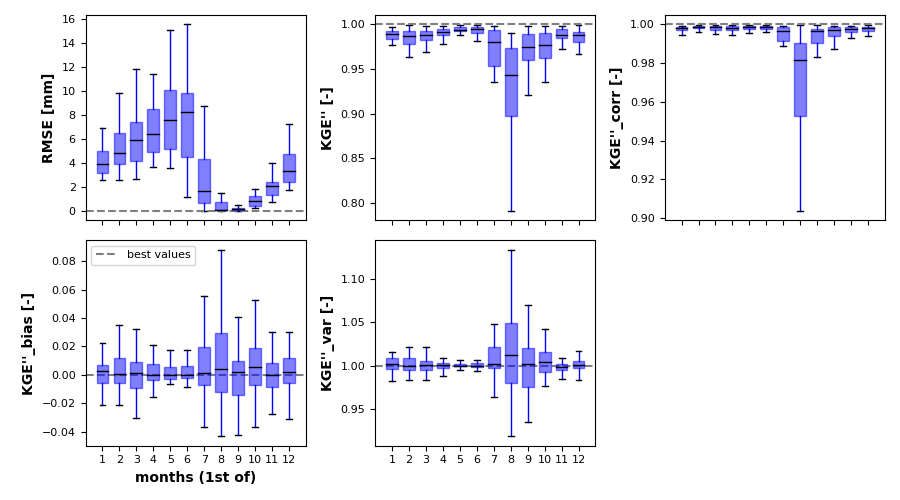

In [147]:
# Plot artificial gap filling evaluation results
fig = plots_artificial_gap_evaluation(evaluation_artificial_gapfill_testbasin_dict)

The boxplots contain results for all SWE stations. For the Bow at Banff, we can see some low scores. This can sometimes happens for certain SWE stations with very few gaps to fill. If various donor stations are used to fill out these gaps, then there are some inconsistencies across infilling values and the overall correlation between the infilling values and the observations is poor.

In [148]:
# Save the figure
fig.savefig(settings['plots_path']+"artificial_gap_filling_evaluation_basin"+test_basin_id+".png", dpi=300)

In [149]:
# Close the figure - please run this as it will ensure that we're not overloading the memory unnecessarily
plt.close(fig)

## Save data
Save the output gap-filled SWE data so we can read them in other Notebooks.

In [169]:
# Save the data
SWE_testbasin_gapfilled_ds.to_netcdf(settings['output_data_path']+"SWE_1979_2022_gapfilled_basin"+test_basin_id+".nc", format="NETCDF4")